In [8]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Used this to create the dataset (no longer needed if you're using the x.npy and y.npy files)

In [14]:
file_dir = 'Data' # change it to your directory path

In [15]:
def process_csv(file_path, channels_of_interest, rows_per_chunk):
    # Load the CSV file
    data = pd.read_csv(file_path)

    # Ensure the data has enough rows
    if len(data) < rows_per_chunk:
        raise ValueError(f"The data file {file_path} contains only {len(data)} rows, but {rows_per_chunk} are required for 10 seconds of data.")

    # Extract the channels of interest and labels
    eeg_data = data[channels_of_interest]
    labels = data.iloc[:, -1]  # Assuming the last column is the label

    # Initialize lists to store the chunks and their labels
    chunks = []
    chunk_labels = []

    # Iterate over the data in chunks
    for start in range(0, len(data), rows_per_chunk):
        end = start + rows_per_chunk
        if end > len(data):
            break  # Ensure we have a complete chunk

        # Extract the chunk and its corresponding labels
        chunk = eeg_data.iloc[start:end]
        chunk_label = labels.iloc[start:end]

        # Determine the label for the chunk
        if chunk_label.sum() == rows_per_chunk:
            chunk_label = 1
        else:
            chunk_label = 0

        # Store the chunk and its label
        chunks.append(chunk.values)
        chunk_labels.append(chunk_label)

    return chunks, chunk_labels


In [16]:
channels_of_interest = ['F7', 'T7', 'P7', 'TP9', 'FT9', 'F8', 'T8', 'P8', 'TP10', 'FT10']

# Extract 2560 rows (10 seconds of data)
sampling_rate = 256  # 256 Hz
duration = 10  # 10 seconds
rows_per_chunk = sampling_rate * duration

In [17]:
X = []
y = []

for filename in os.listdir(file_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(file_dir, filename)
        chunks, chunk_labels = process_csv(file_path, channels_of_interest, rows_per_chunk)

        # Accumulate the chunks and labels
        X.extend(chunks)
        y.extend(chunk_labels)


In [18]:
X = np.array(X)
y = np.array(y)

# Example output to verify
print(f"Total chunks created: {len(X)}")
print(f"Labels distribution: {np.bincount(y)}")

Total chunks created: 1196
Labels distribution: [820 376]


In [19]:
X_path = os.path.join(file_dir, 'x.npy')
y_path = os.path.join(file_dir, 'y.npy')

np.save(X_path, X)
np.save(y_path, y)

Load from here...

In [21]:
X = np.load('Data/x.npy')
y = np.load('Data/y.npy')

In [22]:
num_zeros = np.sum(y == 0)
num_ones = np.sum(y == 1)
total = len(y)

weight_for_zeros = total / (2 * num_zeros)
weight_for_ones = total / (2 * num_ones)

class_weights = torch.tensor([weight_for_zeros, weight_for_ones], dtype=torch.float32)

In [23]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)  # Use float32 for BCEWithLogitsLoss

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
dataset = EEGDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
# class EEGNet(nn.Module):
#     def __init__(self):
#         super(EEGNet, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=10, out_channels=64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool1d(kernel_size=2)
#         self.fc1 = nn.Linear(256 * (2560 // 8), 128)  # Adjust the input size
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 1)  # Single output for binary classification

#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # Change the shape to [batch_size, num_channels, num_timesteps]
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = F.relu(self.conv3(x))
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)  # Flatten the input tensor
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [26]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(256 * 160, 128)  # Adjust the input size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Single output for binary classification
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change the shape to [batch_size, num_channels, num_timesteps]
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EEGNet().to(device)
#model = EEGNet()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
test_accuracies = []

In [28]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()  # Squeeze the output to match the labels shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()  # Squeeze the output to match the labels shape
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {test_accuracy:.4f}')

Epoch 1/100, Loss: 1.3273, Accuracy: 0.8542
Epoch 2/100, Loss: 0.4977, Accuracy: 0.9125
Epoch 3/100, Loss: 0.4009, Accuracy: 0.8708
Epoch 4/100, Loss: 0.2697, Accuracy: 0.9667
Epoch 5/100, Loss: 0.0951, Accuracy: 0.9500
Epoch 6/100, Loss: 0.0393, Accuracy: 0.9542
Epoch 7/100, Loss: 0.1502, Accuracy: 0.9667
Epoch 8/100, Loss: 0.0539, Accuracy: 0.9625
Epoch 9/100, Loss: 0.0334, Accuracy: 0.9583


KeyboardInterrupt: 

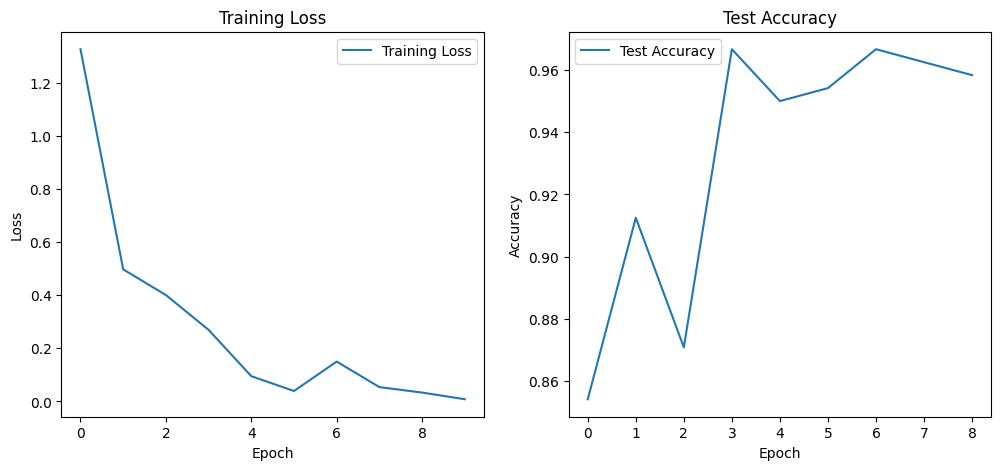

In [29]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()

In [30]:
# Evaluate the model and display the confusion matrix
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()  # Squeeze the output to match the labels shape
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

In [31]:
# Print final test set accuracy
final_test_accuracy = sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
print(f"Final Test Set Accuracy: {final_test_accuracy:.4f}")

Final Test Set Accuracy: 0.9500


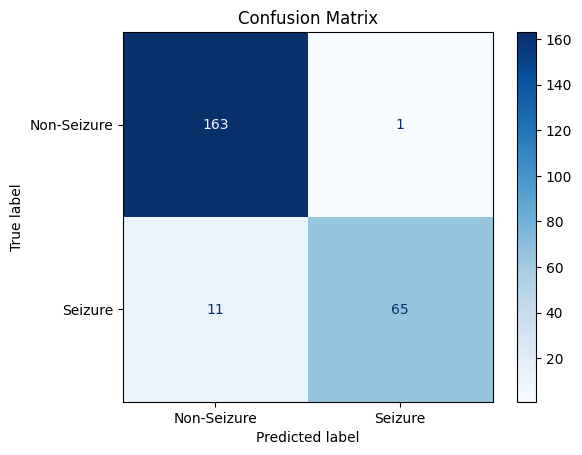

In [32]:
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Seizure', 'Seizure'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Epoch [1/10], Train Loss: 1.0558, Val Loss: 0.4865
Epoch [2/10], Train Loss: 0.4230, Val Loss: 0.3866
Epoch [3/10], Train Loss: 0.3563, Val Loss: 0.3464
Epoch [4/10], Train Loss: 0.2733, Val Loss: 0.2753
Epoch [5/10], Train Loss: 0.2047, Val Loss: 0.2643
Epoch [6/10], Train Loss: 0.0860, Val Loss: 0.2978
Epoch [7/10], Train Loss: 0.0503, Val Loss: 0.3438
Epoch [8/10], Train Loss: 0.1224, Val Loss: 1.0529
Epoch [9/10], Train Loss: 0.1267, Val Loss: 0.1870
Epoch [10/10], Train Loss: 0.0430, Val Loss: 0.3445


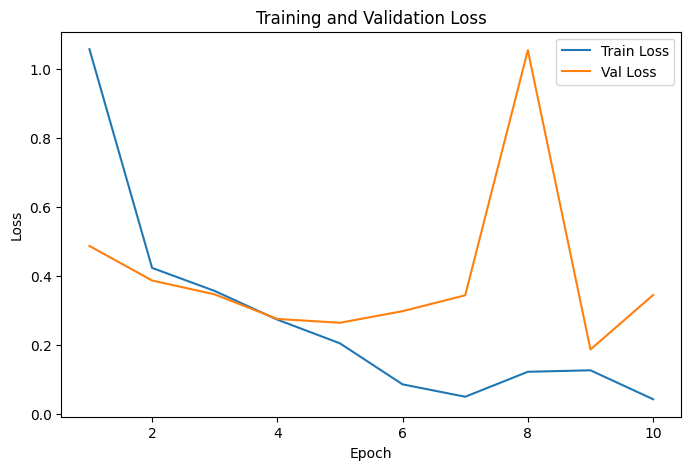

In [43]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the preprocessed EEG data
x_path = os.path.join(file_dir, 'x.npy')
y_path = os.path.join(file_dir, 'y.npy')
X = np.load(x_path)
y = np.load(y_path)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create custom datasets
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create data loaders
train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the client-side model (local layers)
class ClientModel(nn.Module):
    def __init__(self):
        super(ClientModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        return x

# Define the server-side model (cloud layers)
class ServerModel(nn.Module):
    def __init__(self):
        super(ServerModel, self).__init__()
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the models
client_model = ClientModel()
server_model = ServerModel()

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(client_model.parameters()) + list(server_model.parameters()), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    client_model.train()
    server_model.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # Client-side processing
        client_output = client_model(data)

        # Send client_output to the server (cloud) for further processing
        server_output = server_model(client_output)

        # Compute loss and perform backpropagation
        loss = criterion(server_output.squeeze(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # Validation
    client_model.eval()
    server_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_dataloader:
            # Client-side processing
            client_output = client_model(data)

            # Send client_output to the server (cloud) for further processing
            server_output = server_model(client_output)

            # Compute loss
            loss = criterion(server_output.squeeze(), target)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the trained models
client_model_path = os.path.join(file_dir, 'eegnet_client_model.pth')
server_model_path = os.path.join(file_dir, 'eegnet_server_model.pth')
torch.save(client_model.state_dict(), client_model_path)
torch.save(server_model.state_dict(), server_model_path)

In [45]:
import seaborn as sns

Confusion Matrix:
[[158   2]
 [ 17  63]]


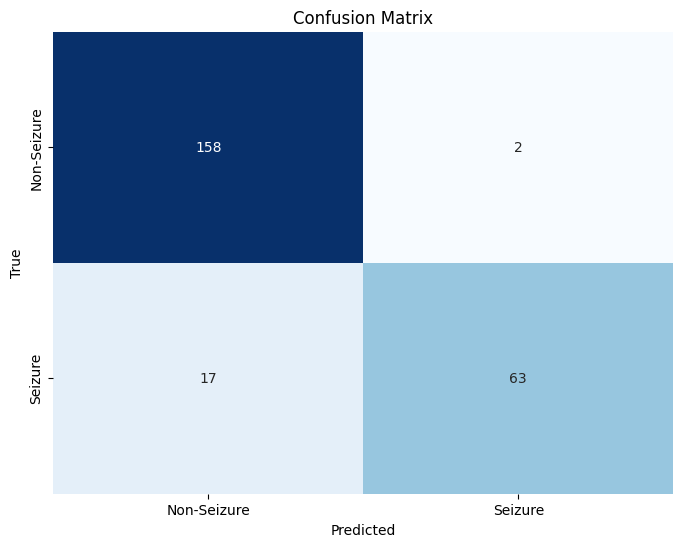

Classification Report:
              precision    recall  f1-score   support

 Non-Seizure       0.90      0.99      0.94       160
     Seizure       0.97      0.79      0.87        80

    accuracy                           0.92       240
   macro avg       0.94      0.89      0.91       240
weighted avg       0.92      0.92      0.92       240



In [47]:
from sklearn.metrics import confusion_matrix, classification_report


# Evaluate the model on the validation set
client_model.eval()
server_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data, target in val_dataloader:
        # Client-side processing
        client_output = client_model(data)

        # Send client_output to the server (cloud) for further processing
        server_output = server_model(client_output)

        # Compute predictions
        predictions = (torch.sigmoid(server_output) > 0.5).float().squeeze()
        y_true.extend(target.numpy())
        y_pred.extend(predictions.numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Seizure', 'Seizure'], yticklabels=['Non-Seizure', 'Seizure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Seizure', 'Seizure']))

# Save the trained models
client_model_path = os.path.join(file_dir, 'eegnet_client_model.pth')
server_model_path = os.path.join(file_dir, 'eegnet_server_model.pth')
torch.save(client_model.state_dict(), client_model_path)
torch.save(server_model.state_dict(), server_model_path)

In [ ]:
##Evaluate privacy

In [52]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity


# Evaluate privacy by comparing raw EEG signal and intermediate output
client_model.eval()
cosine_similarities = []

with torch.no_grad():
    for data, _ in val_dataloader:
        # Client-side processing
        client_output = client_model(data)

        # Flatten the raw EEG signal and intermediate output
        raw_signal = data.view(data.size(0), -1).numpy()
        
        # Reshape the intermediate output to match the dimensions of the raw EEG signal
        intermediate_output = client_output.view(client_output.size(0), -1)
        intermediate_output = nn.functional.interpolate(intermediate_output.unsqueeze(1), size=raw_signal.shape[1], mode='linear', align_corners=False)
        intermediate_output = intermediate_output.squeeze(1).numpy()

        # Compute cosine similarity between raw EEG signal and intermediate output
        similarity = cosine_similarity(raw_signal, intermediate_output)
        cosine_similarities.extend(similarity.diagonal())


# Compute average cosine similarity
avg_cosine_similarity = np.mean(cosine_similarities)
print(f"Average Cosine Similarity: {avg_cosine_similarity:.4f}")



Average Cosine Similarity: -0.0063


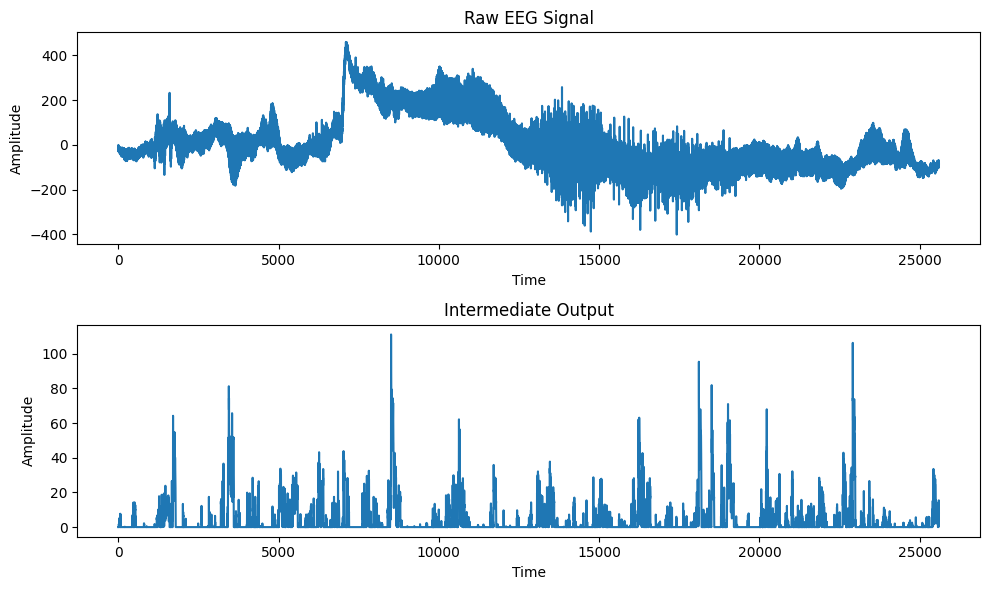

In [53]:
# Plot the raw EEG signal and intermediate output
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(raw_signal[0])
plt.title("Raw EEG Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(intermediate_output[0])
plt.title("Intermediate Output")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [54]:
##Evaluate different metrics

In [56]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mutual_info_score


# Evaluate privacy using multiple metrics
client_model.eval()
cosine_similarities = []
pearson_correlations = []
spearman_correlations = []
mutual_info_scores = []

with torch.no_grad():
    for data, _ in val_dataloader:
        # Client-side processing
        client_output = client_model(data)

        # Flatten the raw EEG signal and intermediate output
        raw_signal = data.view(data.size(0), -1).numpy()

        # Reshape the intermediate output to match the dimensions of the raw EEG signal
        intermediate_output = client_output.view(client_output.size(0), -1)
        intermediate_output = nn.functional.interpolate(intermediate_output.unsqueeze(1), size=raw_signal.shape[1], mode='linear', align_corners=False)
        intermediate_output = intermediate_output.squeeze(1).numpy()

        # Compute cosine similarity between raw EEG signal and intermediate output
        cosine_sim = cosine_similarity(raw_signal, intermediate_output).diagonal()
        cosine_similarities.extend(cosine_sim)

        # Compute Pearson correlation coefficient between raw EEG signal and intermediate output
        pearson_corr = np.array([pearsonr(raw_signal[i], intermediate_output[i])[0] for i in range(data.size(0))])
        pearson_correlations.extend(pearson_corr)

        # Compute Spearman rank-order correlation coefficient between raw EEG signal and intermediate output
        spearman_corr = np.array([spearmanr(raw_signal[i], intermediate_output[i])[0] for i in range(data.size(0))])
        spearman_correlations.extend(spearman_corr)

        # Compute mutual information between raw EEG signal and intermediate output
        mutual_info = np.array([mutual_info_score(raw_signal[i], intermediate_output[i]) for i in range(data.size(0))])
        mutual_info_scores.extend(mutual_info)

# Compute average metrics
avg_cosine_similarity = np.mean(cosine_similarities)
avg_pearson_correlation = np.mean(pearson_correlations)
avg_spearman_correlation = np.mean(spearman_correlations)
avg_mutual_info_score = np.mean(mutual_info_scores)

print(f"Average Cosine Similarity: {avg_cosine_similarity:.4f}")
print(f"Average Pearson Correlation: {avg_pearson_correlation:.4f}")
print(f"Average Spearman Correlation: {avg_spearman_correlation:.4f}")
print(f"Average Mutual Information Score: {avg_mutual_info_score:.4f}")



/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Average Cosine Similarity: -0.0063
Average Pearson Correlation: -0.0012
Average Spearman Correlation: -0.0004
Average Mutual Information Score: 2.4326


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

In [58]:
##Breaking the model at a different layer


Epoch [1/10], Train Loss: 2.0523, Val Loss: 0.4778
Epoch [2/10], Train Loss: 0.5480, Val Loss: 0.4602
Epoch [3/10], Train Loss: 0.4119, Val Loss: 0.4119
Epoch [4/10], Train Loss: 0.3236, Val Loss: 0.3262
Epoch [5/10], Train Loss: 0.2314, Val Loss: 0.3090
Epoch [6/10], Train Loss: 0.1581, Val Loss: 0.1877
Epoch [7/10], Train Loss: 0.0777, Val Loss: 0.1994
Epoch [8/10], Train Loss: 0.0702, Val Loss: 0.1606
Epoch [9/10], Train Loss: 0.1128, Val Loss: 0.3534
Epoch [10/10], Train Loss: 0.0561, Val Loss: 0.2144


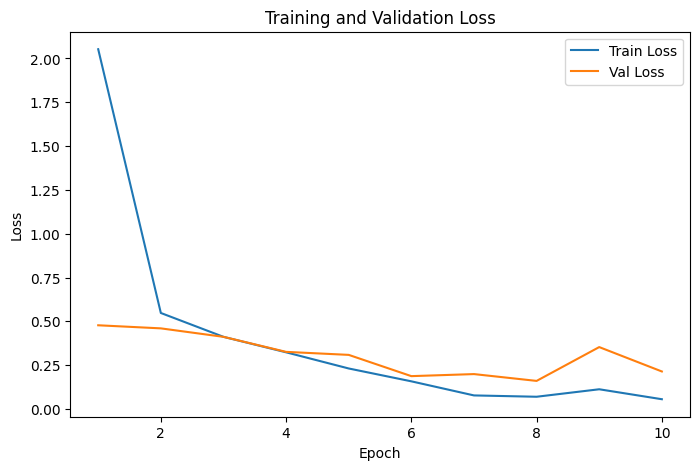

Test Accuracy: 0.9333
Confusion Matrix:
[[159   1]
 [ 15  65]]


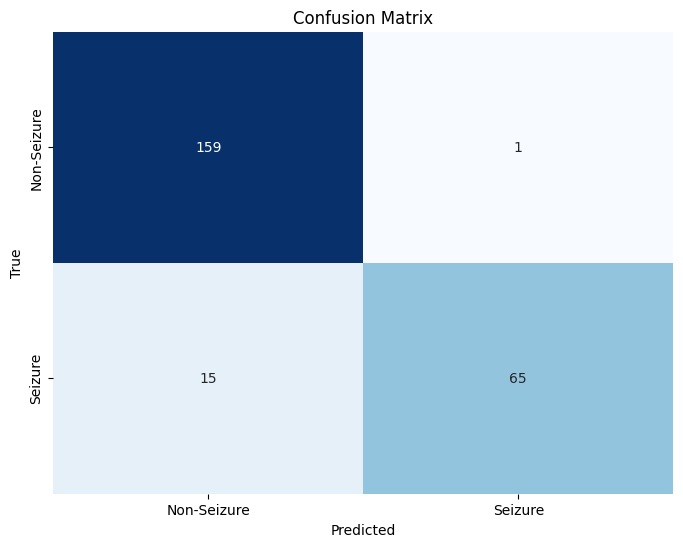

Classification Report:
              precision    recall  f1-score   support

 Non-Seizure       0.91      0.99      0.95       160
     Seizure       0.98      0.81      0.89        80

    accuracy                           0.93       240
   macro avg       0.95      0.90      0.92       240
weighted avg       0.94      0.93      0.93       240



/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Average Cosine Similarity: -0.0081
Average Pearson Correlation: -0.0032
Average Spearman Correlation: -0.0017
Average Mutual Information Score: 2.3704


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

In [61]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the preprocessed EEG data
file_dir = 'Data'
x_path = os.path.join(file_dir, 'x.npy')
y_path = os.path.join(file_dir, 'y.npy')
X = np.load(x_path)
y = np.load(y_path)

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Create custom datasets
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create data loaders
train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the client-side model (local layers)
class ClientModel(nn.Module):
    def __init__(self):
        super(ClientModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        return x

# Define the server-side model (cloud layers)
class ServerModel(nn.Module):
    def __init__(self):
        super(ServerModel, self).__init__()
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)  # Update the input size based on the client_output dimensions
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the models
client_model = ClientModel()
server_model = ServerModel()

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(client_model.parameters()) + list(server_model.parameters()), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    client_model.train()
    server_model.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # Client-side processing
        client_output = client_model(data)

        # Send client_output to the server (cloud) for further processing
        server_output = server_model(client_output)

        # Compute loss and perform backpropagation
        loss = criterion(server_output.squeeze(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # Validation
    client_model.eval()
    server_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_dataloader:
            # Client-side processing
            client_output = client_model(data)

            # Send client_output to the server (cloud) for further processing
            server_output = server_model(client_output)

            # Compute loss
            loss = criterion(server_output.squeeze(), target)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
client_model.eval()
server_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data, target in test_dataloader:
        # Client-side processing
        client_output = client_model(data)

        # Send client_output to the server (cloud) for further processing
        server_output = server_model(client_output)

        # Compute predictions
        predictions = (torch.sigmoid(server_output) > 0.5).float().squeeze()
        y_true.extend(target.numpy())
        y_pred.extend(predictions.numpy())

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Seizure', 'Seizure'], yticklabels=['Non-Seizure', 'Seizure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Seizure', 'Seizure']))

# Evaluate privacy using multiple metrics
client_model.eval()
cosine_similarities = []
pearson_correlations = []
spearman_correlations = []
mutual_info_scores = []

with torch.no_grad():
    for data, _ in test_dataloader:
        # Client-side processing
        client_output = client_model(data)

        # Flatten the raw EEG signal and intermediate output
        raw_signal = data.view(data.size(0), -1).numpy()

        # Reshape the intermediate output to match the dimensions of the raw EEG signal
        intermediate_output = client_output.view(client_output.size(0), -1)
        intermediate_output = nn.functional.interpolate(intermediate_output.unsqueeze(1), size=raw_signal.shape[1], mode='linear', align_corners=False)
        intermediate_output = intermediate_output.squeeze(1).numpy()

        # Compute cosine similarity between raw EEG signal and intermediate output
        cosine_sim = cosine_similarity(raw_signal, intermediate_output).diagonal()
        cosine_similarities.extend(cosine_sim)

        # Compute Pearson correlation coefficient between raw EEG signal and intermediate output
        pearson_corr = np.array([pearsonr(raw_signal[i], intermediate_output[i])[0] for i in range(data.size(0))])
        pearson_correlations.extend(pearson_corr)

        # Compute Spearman rank-order correlation coefficient between raw EEG signal and intermediate output
        spearman_corr = np.array([spearmanr(raw_signal[i], intermediate_output[i])[0] for i in range(data.size(0))])
        spearman_correlations.extend(spearman_corr)

        # Compute mutual information between raw EEG signal and intermediate output
        mutual_info = np.array([mutual_info_score(raw_signal[i], intermediate_output[i]) for i in range(data.size(0))])
        mutual_info_scores.extend(mutual_info)

# Compute average metrics
avg_cosine_similarity = np.mean(cosine_similarities)
avg_pearson_correlation = np.mean(pearson_correlations)
avg_spearman_correlation = np.mean(spearman_correlations)
avg_mutual_info_score = np.mean(mutual_info_scores)

print(f"Average Cosine Similarity: {avg_cosine_similarity:.4f}")
print(f"Average Pearson Correlation: {avg_pearson_correlation:.4f}")
print(f"Average Spearman Correlation: {avg_spearman_correlation:.4f}")
print(f"Average Mutual Information Score: {avg_mutual_info_score:.4f}")

# Save the trained models
client_model_path = os.path.join(file_dir, 'eegnet_client_model_split3.pth')
server_model_path = os.path.join(file_dir, 'eegnet_server_model_split3.pth')
torch.save(client_model.state_dict(), client_model_path)
torch.save(server_model.state_dict(), server_model_path)

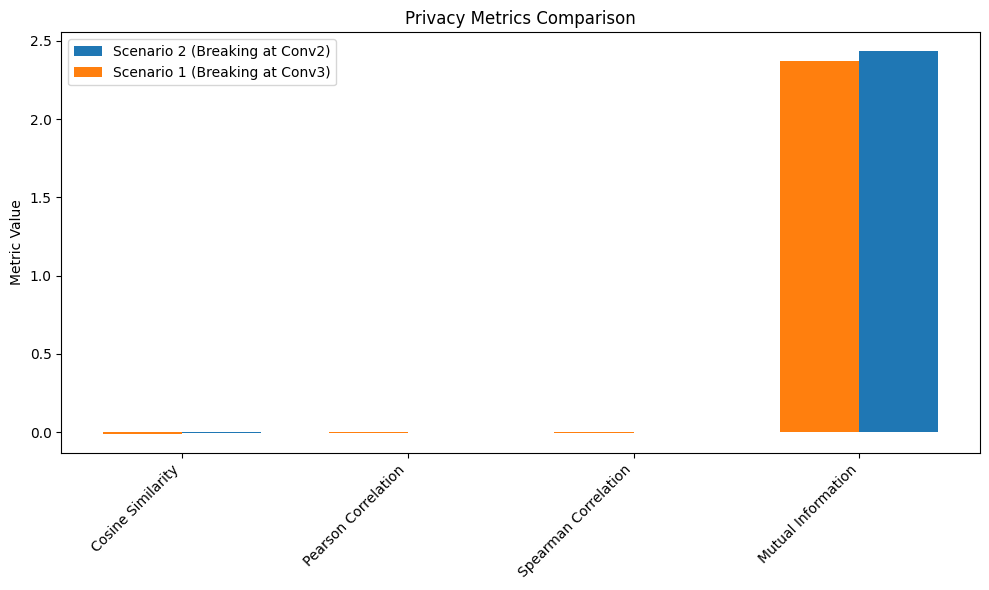

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Privacy metrics for scenario 1 (breaking at a different layer)
cosine_sim_1 = -0.0081
pearson_corr_1 = -0.0032
spearman_corr_1 = -0.0017
mutual_info_1 = 2.3704

# Privacy metrics for scenario 2 (previous results)
cosine_sim_2 = -0.0063
pearson_corr_2 = -0.0012
spearman_corr_2 = -0.0004
mutual_info_2 = 2.4326

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define the metrics and their values for each scenario
metrics = ['Cosine Similarity', 'Pearson Correlation', 'Spearman Correlation', 'Mutual Information']
scenario1_values = [cosine_sim_1, pearson_corr_1, spearman_corr_1, mutual_info_1]
scenario2_values = [cosine_sim_2, pearson_corr_2, spearman_corr_2, mutual_info_2]

# Set the positions of the bars on the x-axis
x = np.arange(len(metrics))

# Set the width of the bars
width = 0.35

# Plot the bars for each scenario
rects2 = ax.bar(x + width/2, scenario2_values, width, label='Scenario 2 (Breaking at Conv2)')

rects1 = ax.bar(x - width/2, scenario1_values, width, label='Scenario 1 (Breaking at Conv3)')

# Add labels and title
ax.set_ylabel('Metric Value')
ax.set_title('Privacy Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout and display the plot
fig.tight_layout()
plt.show()